# remove consecutive values {.unnumbered}

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import warnings
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import seaborn as sns
sns.set(style="ticks", font_scale=1.5)  # white graphs, with large and legible letters

# %matplotlib widget

create data, put some defective windows here and there...

In [2]:
steps = np.random.randint(low=-2, high=2, size=500)
data = steps.cumsum()
date_range = pd.date_range(start='2023-01-01', periods=len(data), freq='1D')
df = pd.DataFrame({'series': data}, index=date_range)

# make sequence of consecutive values
df.loc['2023-06-05':'2023-07-20', 'series'] = 2
df.loc['2023-10-05':'2023-10-25', 'series'] = -150

plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


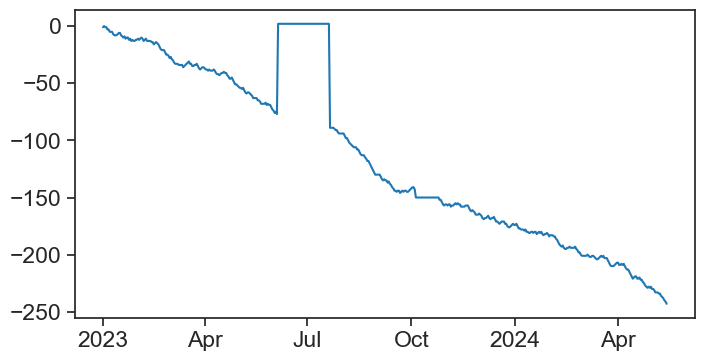

In [3]:
def concise(ax):
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(df['series'], color="tab:blue")
concise(ax)
ax.legend(frameon=False)

nice function, keep that for future reference

In [7]:
# function to copy paste:
def conseq_series(series, N):
    """
    part A:
    1. assume a string of 5 equal values. that's what we want to identify
    2. diff produces a string of only 4 consecutive zeros
    3. no problem, because when applying cumsum, the 4 zeros turn into a plateau of 5, that's what we want
    so far, so good
    part B:
    1. groupby value_grp splits data into groups according to cumsum.
    2. because cumsum is monotonically increasing, necessarily all groups will be composed of neighboring rows, no funny business
    3. what are those groups made of? of rows of column 'series'. this specific column is not too important, because:
    4. count 'counts' the number of elements inside each group.
    5. the real magic here is that 'transform' assigns each row of the original group with the count result.
    6. finally, we can ask the question: which rows belong to a string of identical values greater-equal than some threshold.
    zehu, you now have a mask (True-False) with the same shape as the original series.

    """
    # part A:
    sumsum_series = (
                   (series.diff() != 0)         # diff zero becomes false, otherwise true
                      .astype('int')           # true -> 1  , false -> 0
                      .cumsum()                # cumulative sum, monotonically increasing
                  )
    # part B:
    mask_outliers = (
                    series.groupby(sumsum_series)           # take original series and group it by values of cumsum
                                .transform('count')        # now count how many are in each group, assign result to each existing row. that's what transform does
                                .ge(N)                    # if row count >= than user-defined n_consecutives, assign True, otherwise False
                    )
    
    # apply mask:
    result = pd.Series(np.where(mask_outliers,
                                np.nan,  # use this if mask_outliers is True
                                series), # otherwise
                            index=series.index)
    return result


plot results. it works :)

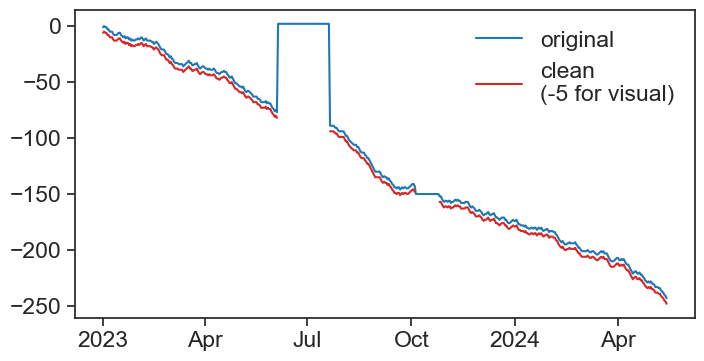

In [8]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(df['series'], color="tab:blue", label='original')
ax.plot(conseq_series(df['series'], 10)-5, c='tab:red', label='clean\n(-5 for visual)')
concise(ax)
ax.legend(frameon=False);